In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/AI_COLAB/detect_line_traffic_sign_YOLOv3
!pwd

/content/drive/My Drive/AI_COLAB/detect_line_traffic_sign_YOLOv3
/content/drive/My Drive/AI_COLAB/detect_line_traffic_sign_YOLOv3


In [4]:
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.models import load_model
from tqdm import tqdm
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
def _main_(image):
    config_path  = "configWithText.json"
    input_path   = "data_raw_yolov3-Copy/" + image
    output_path  = "output/"

    with open(config_path) as config_buffer:    
        config = json.load(config_buffer)

    makedirs(output_path)

    ###############################
    #   Set some parameter
    ###############################       
    net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
    obj_thresh, nms_thresh = 0.5, 0.45

    ###############################
    #   Load the model
    ###############################
    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    infer_model = load_model(config['train']['saved_weights_name'])

    ###############################
    #   Predict bounding boxes 
    ###############################
    if 'webcam' in input_path: # do detection on the first webcam
        video_reader = cv2.VideoCapture(0)

        # the main loop
        batch_size  = 1
        images      = []
        while True:
            ret_val, image = video_reader.read()
            if ret_val == True: images += [image]

            if (len(images)==batch_size) or (ret_val==False and len(images)>0):
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)

                for i in range(len(images)):
                    draw_boxes(images[i], batch_boxes[i], config['model']['labels'], obj_thresh) 
                    cv2.imshow('video with bboxes', images[i])
                images = []
            if cv2.waitKey(1) == 27: 
                break  # esc to quit
        cv2.destroyAllWindows()        
    elif input_path[-4:] == '.mp4': # do detection on a video  
        video_out = output_path + input_path.split('/')[-1]
        video_reader = cv2.VideoCapture(input_path)

        nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

        video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'MPEG'), 
                               50.0, 
                               (frame_w, frame_h))
        # the main loop
        batch_size  = 1
        images      = []
        start_point = 0 #%
        show_window = False
        for i in tqdm(range(nb_frames)):
            _, image = video_reader.read()

            if (float(i+1)/nb_frames) > start_point/100.:
                images += [image]

                if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                    # predict the bounding boxes
                    batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)

                    for i in range(len(images)):
                        # draw bounding boxes on the image using labels
                        draw_boxes(images[i], batch_boxes[i], config['model']['labels'], obj_thresh)   

                        # show the video with detection bounding boxes          
                        if show_window: cv2.imshow('video with bboxes', images[i])  

                        # write result to the output video
                        video_writer.write(images[i]) 
                    images = []
                if show_window and cv2.waitKey(1) == 27: break  # esc to quit

        if show_window: cv2.destroyAllWindows()
        video_reader.release()
        video_writer.release()       
    else: # do detection on an image or a set of images
        image_paths = []

        if os.path.isdir(input_path): 
            for inp_file in os.listdir(input_path):
                image_paths += [input_path + inp_file]
        else:
            image_paths += [input_path]

        image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

        # the main loop
        for image_path in image_paths:
            image = cv2.imread(image_path)
            print(image_path)

            # predict the bounding boxes
            boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
            for box in boxes:
              for i in range(len(config['model']['labels'])):
                if box.classes[i] > obj_thresh:
                  print(config['model']['labels'][i], " ", box.classes[i])

            # draw bounding boxes on the image using labels
            draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
     
            # write the image with bounding boxes to file
            cv2.imwrite(output_path + image_path.split('/')[-1], np.uint8(image))
            from IPython.display import Image
            display(Image(output_path + image_path.split('/')[-1]))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


data_raw_yolov3-Copy/0066.png
0   0.99680644
NoLeft   0.9522457


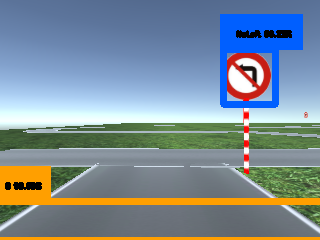

In [11]:
_main_("0066.png")